# Dog breed prediction for Google Cloud ML

In [ ]:
# !pip install cloudmlmagic   # Python 2 only
# !pip install --upgrade google-cloud-vision   # Face detector

In [1]:
%load_ext cloudmlmagic2

In [2]:
%ml_init -projectId udacity-190420 -bucket udacity-190420/dog-breed -requires keras h5py Pillow -scaleTier BASIC -region europe-west1 -runtimeVersion 1.2

In [3]:
%%ml_code
from keras.utils.data_utils import get_file
from keras.models import load_model
model_path = get_file(
            'my_model.hdf5',
            'https://github.com/gregoriomezquita/dog-breed/raw/master/cloud-ml/my_model.hdf5')
my_model = load_model(model_path)
print(my_model.input.name)

Using TensorFlow backend.


reshape_1_input:0


In [4]:
%%ml_code

from keras.applications.inception_v3 import InceptionV3 as keras_model

selected_model= keras_model(weights='imagenet', include_top=False)

In [5]:
%%ml_code

from keras.models import Model
# Concatenate both models
final_model = Model(inputs= [selected_model.input], outputs= [my_model(selected_model.output)])

In [6]:
%%ml_run cloud

import tensorflow as tf
from keras import backend as K

saved_model_path= 'gs://udacity-190420/dog-breed/savedmodel'
#saved_model_path= 'savedmodel'

K.set_learning_phase(0)  # test
sess = K.get_session()

from tensorflow.python.framework import graph_util

# Make GraphDef of Transfer Model
g_trans = sess.graph
g_trans_def = graph_util.convert_variables_to_constants(sess,
                                                        g_trans.as_graph_def(),
                                                        [final_model.output.name.replace(':0','')])

# Image Converter Model
with tf.Graph().as_default() as g_input:
    input_b64 = tf.placeholder(shape=(1,), dtype=tf.string, name='input')
    input_bytes = tf.decode_base64(input_b64[0])
    image = tf.image.decode_image(input_bytes)
    image_f = tf.image.convert_image_dtype(image, dtype=tf.float32)
    input_image = tf.expand_dims(image_f, 0)
    output = tf.identity(input_image, name='input_image')

g_input_def = g_input.as_graph_def()



with tf.Graph().as_default() as g_combined:
    x = tf.placeholder(tf.string, name="input_b64")

    im, = tf.import_graph_def(g_input_def,
                              input_map={'input:0': x},
                              return_elements=["input_image:0"])

    pred, = tf.import_graph_def(g_trans_def,
                                input_map={final_model.input.name: im,
                                          'batch_normalization_1/keras_learning_phase:0': False},
                                return_elements=[final_model.output.name])

    with tf.Session() as sess2:
        inputs = {"inputs": tf.saved_model.utils.build_tensor_info(x)}
        outputs = {"outputs": tf.saved_model.utils.build_tensor_info(pred)}
        signature = tf.saved_model.signature_def_utils.build_signature_def(
            inputs=inputs,
            outputs=outputs,
            method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
        )

        # save as SavedModel
        b = tf.saved_model.builder.SavedModelBuilder(saved_model_path)
        b.add_meta_graph_and_variables(sess2,
                                       [tf.saved_model.tag_constants.SERVING],
                                       signature_def_map={'serving_default': signature})
        b.save()

{u'trainingOutput': {}, u'trainingInput': {u'runtimeVersion': u'1.2', u'packageUris': [u'gs://udacity-190420/dog-breed/mlmagic__1516563059.tar.gz'], u'region': u'europe-west1', u'pythonModule': u'trainer.task'}, u'jobId': u'mlmagic__1516563059', u'state': u'QUEUED', u'etag': u'HDZewnJ1mAA=', u'createTime': u'2018-01-21T19:31:19Z'}


In [9]:
#!gcloud ml-engine models create DogBreed --regions [europe-west1]
!gcloud ml-engine versions create v1 --model DogBreed --origin gs://udacity-190420/dog-breed/savedmodel --runtime-version 1.2 

Creating version (this might take a few minutes)......done.                    


In [10]:

from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors

PROJECTID = 'udacity-190420'
projectID = 'projects/{}'.format(PROJECTID)
modelName = 'DogBreed'
modelID = '{}/models/{}'.format(projectID, modelName)

credentials = GoogleCredentials.get_application_default()
ml = discovery.build('ml', 'v1', credentials=credentials)

In [72]:
import base64
import json
import os.path
import numpy as np
from io import BytesIO
from keras.preprocessing import image

def load_dog_names(file_name):
    with open(file_name, 'r') as f:
        return json.load(f)
    
def predict_raw(data):
    b64_x = base64.urlsafe_b64encode(data)
    input_instance = dict(inputs=b64_x)
    input_instance = json.loads(json.dumps(input_instance))
    request_body = {"instances": [input_instance]}

    request = ml.projects().predict(name=modelID, body=request_body)
    try:
        response = request.execute()
    except errors.HttpError as err:
        # Something went wrong with the HTTP transaction.
        # To use logging, you need to 'import logging'.
        print('There was an HTTP error during the request:')
        print(err._get_reason())

    if response.get('error') != None: print(response)
    else:
        predictions= response.get('predictions')[0].get('outputs')
        #print(type(predictions), predictions)
        max= np.argmax(predictions)
        accuracy= predictions[max]* 100
        return dog_names[max], accuracy
    return '', 0.0

def predict(img_path):
    extension = os.path.splitext(img_path)[1][1:].upper()
    if extension== 'JPG': extension= 'JPEG'
    img = image.load_img(img_path, target_size=(224, 224))
    buf= BytesIO()
    img.save(buf, format= extension)
    b64_x= buf.getvalue()
    return predict_raw(b64_x)

dog_names= load_dog_names('../dog_names.json')

In [73]:
from glob import glob

files= sorted(glob("../images/*"))
for img_path in files:
    breed, acc= predict(img_path)
    print('%30s : %s (%.2f)' % (img_path, breed, acc))


../images/American_water_spaniel_00648.jpg : American water spaniel (98.56)
  ../images/Brittany_02625.jpg : Brittany (100.00)
../images/Curly-coated_retriever_03896.jpg : Curly-coated retriever (100.00)
../images/Labrador_retriever_06449.jpg : Labrador retriever (93.04)
../images/Labrador_retriever_06455.jpg : Labrador retriever (99.66)
../images/Labrador_retriever_06457.jpg : Labrador retriever (100.00)
../images/Welsh_springer_spaniel_08203.jpg : Welsh springer spaniel (99.98)
      ../images/sample_cnn.png : Great pyrenees (27.24)
../images/sample_dog_output.png : Greyhound (69.87)
../images/sample_human_output.png : Dalmatian (23.92)


https://dog.ceo/api/img/bulldog-french/n02108915_3153.jpg
French bulldog (99.98)


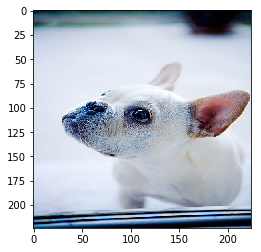

In [86]:
from io import BytesIO
from keras.preprocessing import image
import requests
import matplotlib.pyplot as plt                        
%matplotlib inline

#r = requests.get('http://thecatapi.com/api/images/get?format=src&type=png')
r = requests.get('https://dog.ceo/api/breeds/image/random')
if r.status_code == requests.codes.ok:  # image returned OK
    img_url= json.loads(r.content).get('message')
    r.close() 
    print(img_url)
    r = requests.get(img_url)
    if r.status_code == requests.codes.ok:
        raw_img = BytesIO(r.content)  # create BytesIO object from the request
        r.close()  # close the get request
        img = image.load_img(raw_img, target_size=(224, 224))
        buf= BytesIO()
        img.save(buf, format= extension)
        b64_x= buf.getvalue()
        breed, acc= predict_raw(b64_x)
        print('%s (%.2f)' % (breed, acc))

plt.imshow(img)
plt.show()

https://dog.ceo/api/img/papillon/n02086910_8590.jpg
(224, 224)
Papillon (100.00)


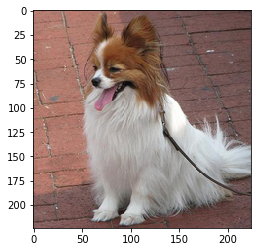

In [123]:
from PIL import Image, ImageOps
from StringIO import StringIO
import requests
import matplotlib.pyplot as plt                        
%matplotlib inline

r = requests.get('https://dog.ceo/api/breeds/image/random')
if r.status_code == requests.codes.ok:  # image returned OK
    img_url= json.loads(r.content).get('message')
    r.close() 
    print(img_url)
    r = requests.get(img_url)
    if r.status_code == requests.codes.ok:
        image = Image.open(StringIO(r.content))
        #image.thumbnail([224, 224], Image.ANTIALIAS)
        image = ImageOps.fit(image, [224, 224], Image.ANTIALIAS)
        print(image.size)
        image_io = StringIO()
        image.save(image_io, format='JPEG')
        b64_x= image_io.getvalue()
        breed, acc= predict_raw(b64_x)
        print('%s (%.2f)' % (breed, acc))
        
plt.imshow(image)
plt.show()
